# Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
5. 4square_channel.png Four square = imagery, surface, bed&surface, change
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import pickle

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [3]:
new_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
old_gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/1516_gprlines.shp')
old_gpr['camp'] = 'KIS2' 
bed_gdf = pd.concat([new_gpr,old_gpr])
gdf = bed_gdf[bed_gdf.camp =='KIS2'].copy()
ngpr = new_gpr[new_gpr.camp =='KIS2'].copy()

In [4]:
gdf.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'Unnamed_ 1', 'SEQnum',
       'camp', 'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object')

In [5]:
x_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_x.npy')
y_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_points_y.npy')
it_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_ice_thickn.npy')
ib_new = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_line2line_interpbydist_icebase.npy')

In [6]:

#load REMA dem
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)
im_REMA = im_REMA - 3.9
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d

In [7]:
# direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

# xv = np.load(direc + 'x_grid' +'.npy')
# yv = np.load(direc + 'y_grid' +'.npy')
# thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
# extent_l2l = np.load(direc +'extent.npy')
# ice_base = np.load(direc +'_ice_base.npy')
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_gridded_'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickn.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [8]:
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

# 5) plot radar lines

In [9]:
# bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('camp == "KIS2"  & line_name != "linedownchan" & line_name != "lineback2camp"')
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp').query('camp == "KIS2"  & line_name != "lineback2camp"')
# bed_gdf = bed_gdf[bed_gdf.camp =='KIS2']
bed_gdf.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'Unnamed_ 1', 'SEQnum',
       'camp', 'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object')

In [10]:
bed_gdf.line_name.unique()

array(['line7', 'line9', 'line0', 'line10', 'line11', 'line12', 'line13',
       'line14', 'line1', 'line2', 'line3', 'line4', 'line6', 'line7p25',
       'line7p5', 'line7p75', 'line8', 'lineAPREScross', 'lineAPRESdown',
       'linedownchan', 'lineupchan', 'left02', 'left1011', 'left1213',
       'left1415', 'left35', 'left46', 'left79', 'left810', 'right1112',
       'right1314', 'right13', 'right24', 'right68', 'right910', 'line5'],
      dtype=object)

In [11]:
print(bed_gdf[bed_gdf.line_name == 'line8'].x.iloc[0],bed_gdf[bed_gdf.line_name == 'line8'].y.iloc[1])

-383054.1 -725861.5


In [12]:
#smooth REMA dem for contours
im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
del im_REMA_d,im_REMA_c

In [13]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

In [14]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

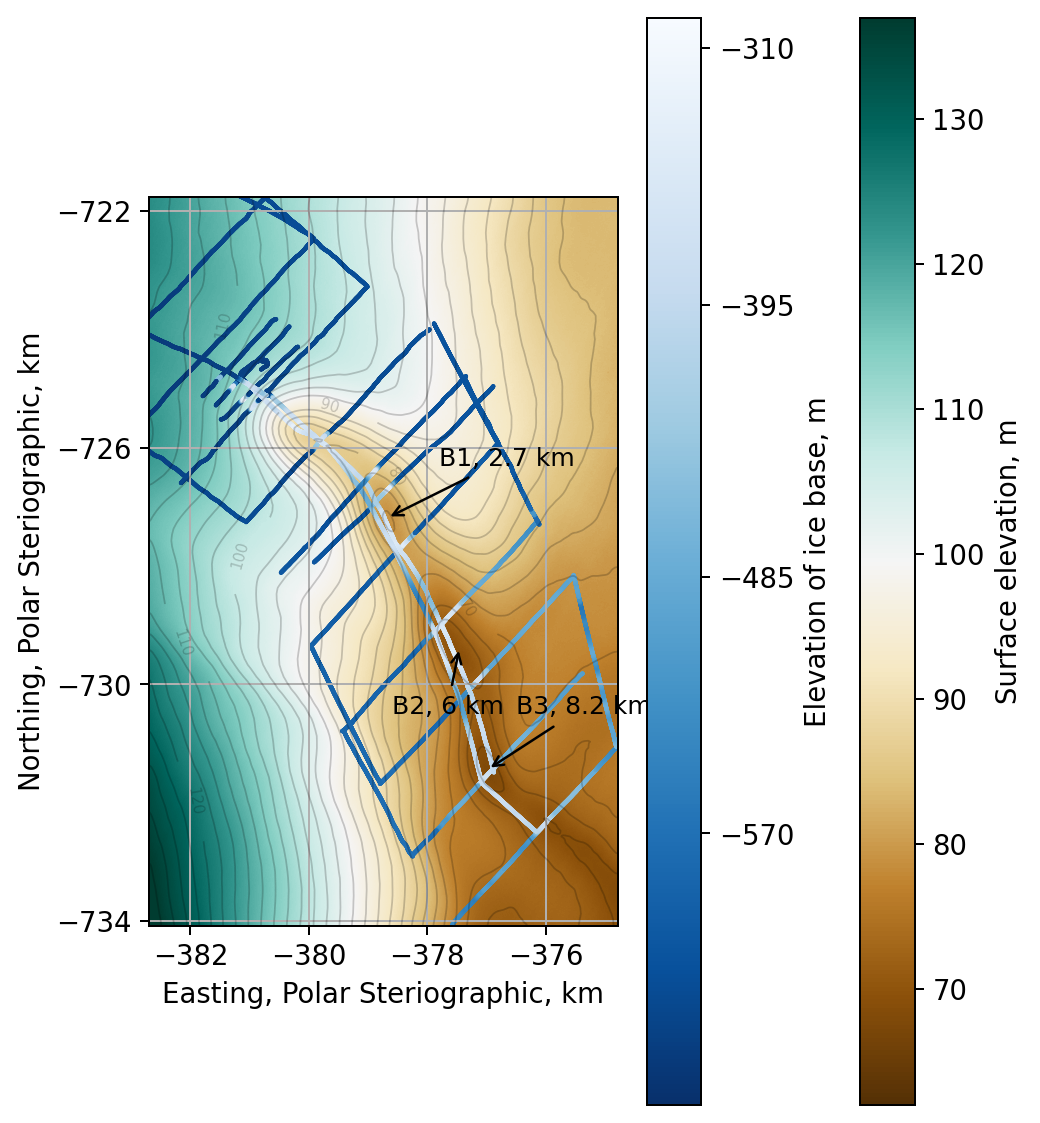

In [15]:
plt.figure( dpi=180,figsize=(6,8))

samp=50
plt.rcParams.update({'font.size': 11})



plt.imshow(im_REMA+geoid_correction,extent=np.array(extent_REMA)/1000,vmin=15+geoid_correction,vmax=90+geoid_correction, cmap='BrBG')
cb = plt.colorbar( pad = 0.15)
cb.set_label('Surface elevation, m')
CS1 =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction+res_correction,
                      30,vmin=15+geoid_correction+res_correction,vmax=90+geoid_correction+res_correction , 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.2,linewidths=0.7)

plt.clabel(CS1,CS1.levels[0::4], inline=1,  fmt='%i',fontsize=6)
plt.scatter(bed_gdf.x/1000, bed_gdf.y/1000, c=bed_gdf.bed+geoid_correction + res_correction,s=0.5,vmin=-700+geoid_correction+res_correction,vmax=-340+geoid_correction+res_correction,cmap='Blues_r')
# cb2 = plt.colorbar()
# cb2.set_label('ice base elevation, m')
plt.xlabel('Easting, Polar Steriographic, km')
plt.ylabel('Northing, Polar Steriographic, km')
# basecolour_surfcontour

plt.annotate( 'B1, 2.7 km',(-378.7, -727.2),xytext=(-378.8+1, -727.3+1),arrowprops=dict(arrowstyle='->'),fontsize=10)
plt.annotate( 'B2, 6 km',(-377.45, -729.35),xytext=(-377.6-1, -729.5-1),arrowprops=dict(arrowstyle='->'),fontsize=10)
plt.annotate( 'B3, 8.2 km',(-377.0, -731.45),xytext=(-377.5+1, -731.5+1),arrowprops=dict(arrowstyle='->'),fontsize=10)

plt.xlim([xmin/1000,xmax/1000])
plt.ylim([ymin/1000,ymax/1000])
plt.xticks(xticks)
plt.yticks(yticks)
cb3 = plt.colorbar()
cb3.set_label('Elevation of ice base, m')
cb3.set_ticks(np.round(np.linspace(-350+geoid_correction + res_correction,-700+geoid_correction + res_correction,5)/5)*5)
plt.grid()
plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/radarlines_surfcolour.png')
plt.show()

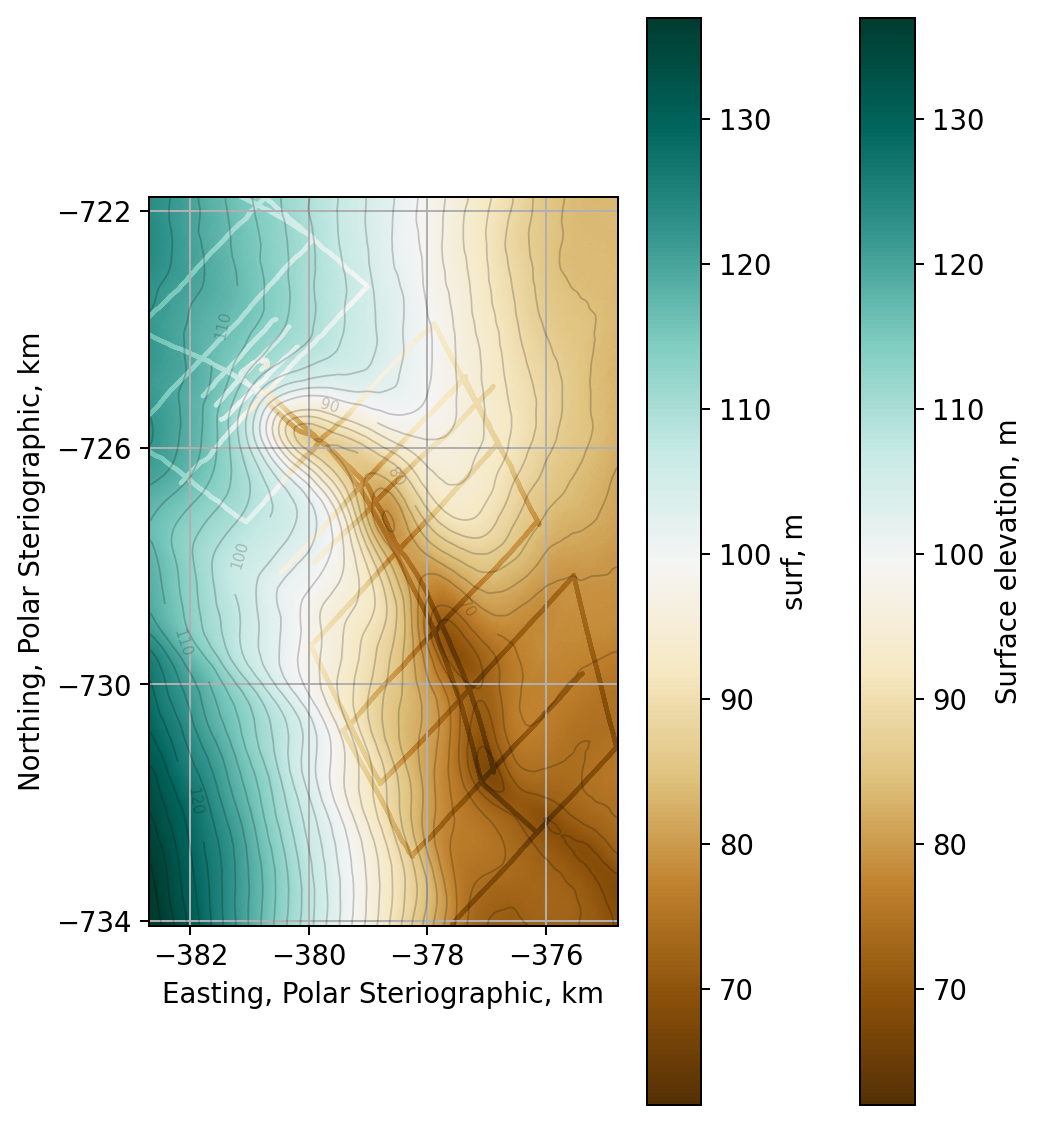

In [16]:
plt.figure( dpi=180,figsize=(6,8))

samp=50
plt.rcParams.update({'font.size': 11})



plt.imshow(im_REMA+geoid_correction,extent=np.array(extent_REMA)/1000,vmin=15+geoid_correction,vmax=90+geoid_correction, cmap='BrBG')
cb = plt.colorbar( pad = 0.15)
cb.set_label('Surface elevation, m')
CS1 =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction+res_correction,
                      30,vmin=15+geoid_correction+res_correction,vmax=90+geoid_correction+res_correction , 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.2,linewidths=0.7)

plt.clabel(CS1,CS1.levels[0::4], inline=1,  fmt='%i',fontsize=6)
plt.scatter(bed_gdf.x/1000, bed_gdf.y/1000, c=bed_gdf.surf+geoid_correction + res_correction,s=0.5,vmin=15+geoid_correction,vmax=90+geoid_correction,cmap='BrBG')

plt.xlabel('Easting, Polar Steriographic, km')
plt.ylabel('Northing, Polar Steriographic, km')
# basecolour_surfcontour

# plt.annotate( 'B1, 2.7 km',(-378.7, -727.2),xytext=(-378.8+1, -727.3+1),arrowprops=dict(arrowstyle='->'),fontsize=10)
# plt.annotate( 'B2, 6 km',(-377.45, -729.35),xytext=(-377.6-1, -729.5-1),arrowprops=dict(arrowstyle='->'),fontsize=10)
# plt.annotate( 'B3, 8.2 km',(-377.0, -731.45),xytext=(-377.5+1, -731.5+1),arrowprops=dict(arrowstyle='->'),fontsize=10)

plt.xlim([xmin/1000,xmax/1000])
plt.ylim([ymin/1000,ymax/1000])
plt.xticks(xticks)
plt.yticks(yticks)
cb3 = plt.colorbar()
cb3.set_label('surf, m')
# cb3.set_ticks(np.round(np.linspace(-350+geoid_correction + res_correction,-700+geoid_correction + res_correction,5)/5)*5)
plt.grid()

plt.show()

In [17]:
bed_gdf.keys()

Index(['CDP', 'x', 'y', 'DELAY', 'line_name', 'surf', 'Unnamed_ 1', 'SEQnum',
       'camp', 'time_UTC', 'ice_thickn', 'bed', 'geometry'],
      dtype='object')

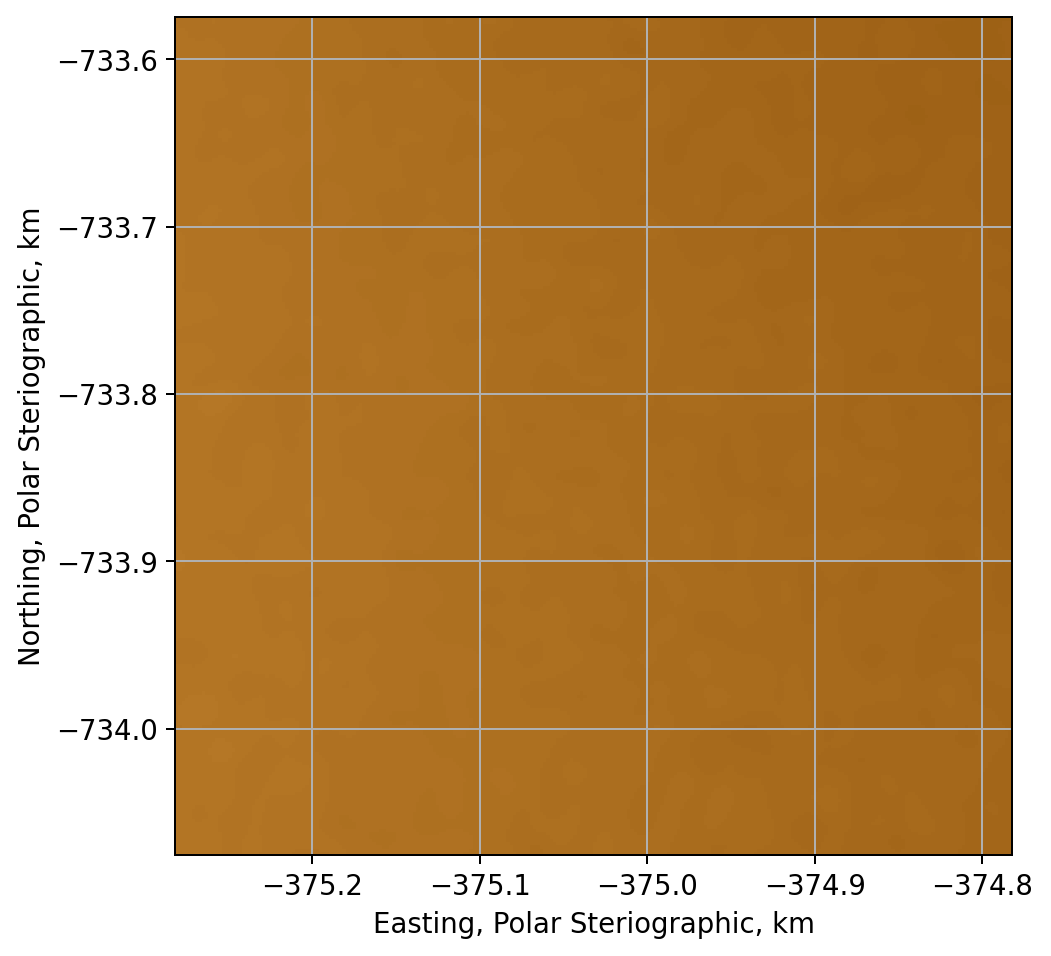

In [14]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})


plt.imshow(im_REMA,extent=np.array(extent_REMA)/1000,vmin=15,vmax=90, cmap='BrBG')
# cb = plt.colorbar()
# cb.set_label('surface elevation, m')

plt.scatter(bed_gdf.x/1000, bed_gdf.y/1000, c=bed_gdf.bed,vmin=-700,vmax=-340,cmap='Blues_r')
# cb2 = plt.colorbar()
# cb2.set_label('ice base elevation, m')
plt.xlabel('Easting, Polar Steriographic, km')
plt.ylabel('Northing, Polar Steriographic, km')
# basecolour_surfcontour

plt.xlim([xmax/1000 - 0.5,xmax/1000])
plt.ylim([ymin/1000,ymin/1000+0.5])
plt.grid()
# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/radarlines_surfcolour.png')
plt.show()